# Assignment 2, 04/22/2018

## Prepared by Duygu Sonmez Tabak

In this assignment, we will build a Decision Tree classifier model design that can distinguish between red wine and white wine. Our classifier must correctly distinguish between red and white wine for at least 95% of the samples in a set of 6497 test samples of red and white wine.


## Importing Libraries

In [169]:
# Import the libraries
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier  
from sklearn import datasets, metrics
import matplotlib.pyplot as plt

## Loading & Inspecting Dataset

In [170]:
# Load in the data with 'read_csv()'
wine = pd.read_csv("/Users/duygusonmez/Desktop/Assignment1/RedWhiteWine.csv",
                     header=None)

Let's take a look at the dataset.

In [171]:
wine.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,6498,6498,6498,6498,6498,6498,6498,6498,6498,6498,6498,6498,6498
unique,107,188,90,317,215,136,277,999,109,112,112,8,3
top,6.8,0.28,0.3,2,0.044,29,111,0.9972,3.16,0.5,9.5,6,0
freq,354,286,337,235,206,183,72,69,200,276,367,2836,4898


In [172]:
wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Class
1,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1
2,7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5,1
3,7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5,1
4,11.2,0.28,0.56,1.9,0.075,17,60,0.998,3.16,0.58,9.8,6,1


## Cleaning the Dataset

Since the dataset has no missing values and categorical attributes, we don't need to deal with them in this particular case.

In [173]:
# Assigning column names
num_features = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", 
                "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", 
                "density", "pH", "sulphates", "alcohol", "quality", "Class"]

wine.columns = num_features

In [174]:
# Dropping the first row
wine.drop(wine.index[0], inplace=True)

We will remove the quality attribute which is not needed for this assignment.

In [175]:
wine.drop(['quality'], axis = 1, inplace = True)

In [176]:
wine.head(1)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Class
1,7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,1


### Scaling the Dataset

We need to scale numeric attributes to perform classification with higher accuracy.

First, we need to convert each attribute to numeric to have them scaled.

In [177]:
#All attributes except 'Class'. 
#Since it is already binary, we don't need it to be converted.
features_to_scale = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", 
                     "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", 
                     "density", "pH", "sulphates", "alcohol"]

In [178]:
#Converting each column to numeric 
for each in features_to_scale:
    wine[each] = pd.to_numeric(wine[each])

In [179]:
for each in features_to_scale:
    mean, std = wine[each].mean(), wine[each].std()
    wine.loc[:, each] = (wine[each] - mean)/std

In [180]:
wine.head(2)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Class
1,0.142462,2.188664,-2.192664,-0.744721,0.569914,-1.100055,-1.446247,1.034913,1.812950,0.193082,-0.915394,1
2,0.451001,3.281982,-2.192664,-0.597594,1.197883,-0.311296,-0.862402,0.701432,-0.115064,0.999502,-0.580023,1


In [181]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 1 to 6497
Data columns (total 12 columns):
fixed_acidity           6497 non-null float64
volatile_acidity        6497 non-null float64
citric_acid             6497 non-null float64
residual_sugar          6497 non-null float64
chlorides               6497 non-null float64
free_sulfur_dioxide     6497 non-null float64
total_sulfur_dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
Class                   6497 non-null object
dtypes: float64(11), object(1)
memory usage: 659.9+ KB


### Splitting the Training and Testing Data

In [182]:
msk = np.random.rand(wine.shape[0]) <= 0.8

In [183]:
wine_train = wine.iloc[msk, 0:11]
wine_train_target = wine.iloc[msk, 11]
wine_test = wine.iloc[~msk, 0:11]
wine_test_target = wine.iloc[~msk, 11]

In [184]:
wine_train.head(1)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
1,0.142462,2.188664,-2.192664,-0.744721,0.569914,-1.100055,-1.446247,1.034913,1.81295,0.193082,-0.915394


In [185]:
len(wine_train), len(wine_test)

(5200, 1297)

### Generating the Decision Tree Classifier Model 

Here we will create a function to train our model and to calculate it's accuracy.
* Classification targets should be represented as integers or as strings. That's why it's converted to string in the code below.

In [186]:
#Build the model

class DecisionTree:
    modelName = ""
    tree_model = None
    y_pred = None
    
    def __init__(self, modelName):
        self.modelName = modelName
    
    def train(self, trainData, trainDataTarget):
        tree = DecisionTreeClassifier(criterion = 'entropy', random_state=5)
        self.tree_model = tree.fit(trainData.astype(str), trainDataTarget.astype(str))
        
    def findAccuracyUsingTestData(self, testData, testDataTarget):
        self.y_pred = self.tree_model.predict(testData)
        misclassified_points = (testDataTarget.astype(str) != self.y_pred).sum()
        print("ACCURACY FOR " + self.modelName)
        print("Number of mislabeled points out of a total %d points : %d"%(testData.shape[0], misclassified_points))
        print("Accuracy = %.2f"%(round((testData.shape[0] - float(misclassified_points))/testData.shape[0]*100,2)))

    def determineAUC(self, testDataTarget):
        fpr, tpr,_ = metrics.roc_curve(testDataTarget.astype(float), self.y_pred.astype(float))
        print(self.modelName + " AUC: " + str(metrics.auc(fpr, tpr)))
        plt.plot(fpr, tpr)
        plt.show()

### Validating & Evaluating the Decision Tree Model

Now we train our model using the training data. After training the model we will calculate the accuracy of the trained model by running predictions on test data and comparing results.

##### Using all attributes

In [187]:
#Run for all columns
allColumnsModel = DecisionTree("Model Using All Attributes")
allColumnsModel.train(wine_train, wine_train_target)
allColumnsModel.findAccuracyUsingTestData(wine_test, wine_test_target)

ACCURACY FOR Model Using All Attributes
Number of mislabeled points out of a total 1297 points : 10
Accuracy = 99.23


We will also calculate and plot the AUC for our classifier that is using all attributes.

Model Using All Attributes AUC: 0.987020200453


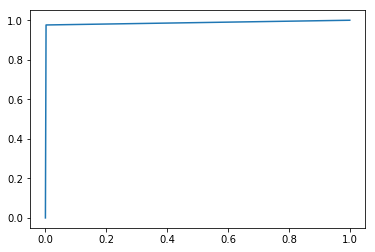

In [188]:
allColumnsModel.determineAUC(wine_test_target)

##### Using subsets of attributes 

Now, we want to use a subset of attributes to achive a better accuracy. We will use a Random Forest classifier to determine the most important attributes that should be used in our next model.

In [189]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [190]:
# Build the model
names = wine.columns.values
rfc = RandomForestClassifier()
rfc.fit(wine_train.astype(str), wine_train_target.astype(str))

# Print the results
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.3413, 'chlorides'), (0.2105, 'total_sulfur_dioxide'), (0.0997, 'density'), (0.0975, 'volatile_acidity'), (0.0872, 'free_sulfur_dioxide'), (0.0665, 'residual_sugar'), (0.0455, 'sulphates'), (0.0211, 'fixed_acidity'), (0.015, 'pH'), (0.0094, 'alcohol'), (0.0063, 'citric_acid')]


We determined the importance of each attribute. We can also plot the attributes based on their importance.

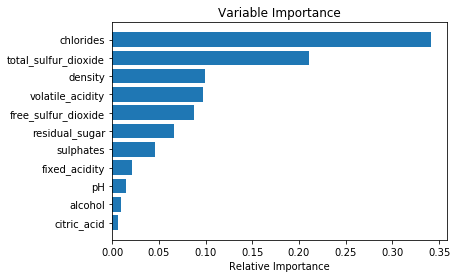

In [191]:
# Isolate feature importances 
importance = rfc.feature_importances_

# Sort the feature importances 
sorted_importances = np.argsort(importance)

# Insert padding
padding = np.arange(len(names)-1) + 0.5

# Plot the data
plt.barh(padding, importance[sorted_importances], align='center')

# Customize the plot
plt.yticks(padding, names[sorted_importances])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")

# Show the plot
plt.show()

##### The model is generated using three attributes - ( chlorides, total_sulfur_dioxide, volatile_acidity )

In [192]:
wine_train_subset = wine.loc[msk, ['chlorides', 'total_sulfur_dioxide', 'volatile_acidity']]
wine_train_target_subset = wine.iloc[msk, 11]
wine_test_subset = wine.loc[~msk, ['chlorides', 'total_sulfur_dioxide', 'volatile_acidity',]]
wine_test_target_subset = wine.iloc[~msk, 11]

In [193]:
wine_train_subset.head(1)

,chlorides,total_sulfur_dioxide,volatile_acidity
1,0.569914,-1.446247,2.188664


In [194]:
#Generate the model for a subset of columns
threeColumnsModel = DecisionTree("Model Using a Subset of Attributes")
threeColumnsModel.train(wine_train_subset, wine_train_target_subset)
threeColumnsModel.findAccuracyUsingTestData(wine_test_subset, wine_test_target_subset)

ACCURACY FOR Model Using a Subset of Attributes
Number of mislabeled points out of a total 1297 points : 18
Accuracy = 98.61


When we use a subset of attributes as opposed to all of the attributes, the accuracy will drop slightly.

Model Using a Subset of Attributes AUC: 0.981889409501


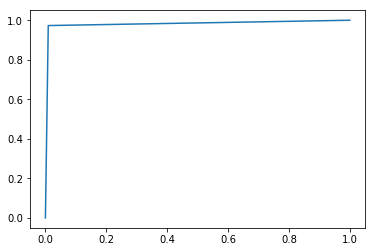

In [195]:
threeColumnsModel.determineAUC(wine_test_target_subset)

##### The model is generated using two attributes - ( chlorides, total_sulfur_dioxide )

In [196]:
wine_train_subset1 = wine.loc[msk, ['chlorides', 'total_sulfur_dioxide']]
wine_train_target_subset1 = wine.iloc[msk, 11]
wine_test_subset1 = wine.loc[~msk, ['chlorides', 'total_sulfur_dioxide']]
wine_test_target_subset1 = wine.iloc[~msk, 11]

In [197]:
#Generate the model for a subset of columns
twoColumnsModel = DecisionTree("Model Using a Subset of Attributes")
twoColumnsModel.train(wine_train_subset1, wine_train_target_subset1)
twoColumnsModel.findAccuracyUsingTestData(wine_test_subset1, wine_test_target_subset1)

ACCURACY FOR Model Using a Subset of Attributes
Number of mislabeled points out of a total 1297 points : 24
Accuracy = 98.15


Model Using a Subset of Attributes AUC: 0.974879759208


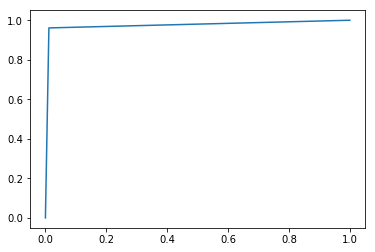

In [198]:
twoColumnsModel.determineAUC(wine_test_target_subset)

##### The model is generated using only one attribute - ( chlorides )

In [199]:
wine_train_subset2 = wine.loc[msk, ['chlorides']]
wine_train_target_subset2 = wine.iloc[msk, 11]
wine_test_subset2 = wine.loc[~msk, ['chlorides']]
wine_test_target_subset2 = wine.iloc[~msk, 11]

In [200]:
#Generate the model for a subset of columns
oneColumnModel = DecisionTree("Model Using a Subset of Attributes")
oneColumnModel.train(wine_train_subset2, wine_train_target_subset2)
oneColumnModel.findAccuracyUsingTestData(wine_test_subset2, wine_test_target_subset2)

ACCURACY FOR Model Using a Subset of Attributes
Number of mislabeled points out of a total 1297 points : 92
Accuracy = 92.91


When we use only one attribute, the accuracy drop below 95%. Based on this experiment, the minimum number of attributes that we should use to satisfy 95% is two. 

##### Visualizing the Decision Tree model that we built using two attributes

In [201]:
from graphviz import Source
from sklearn import tree

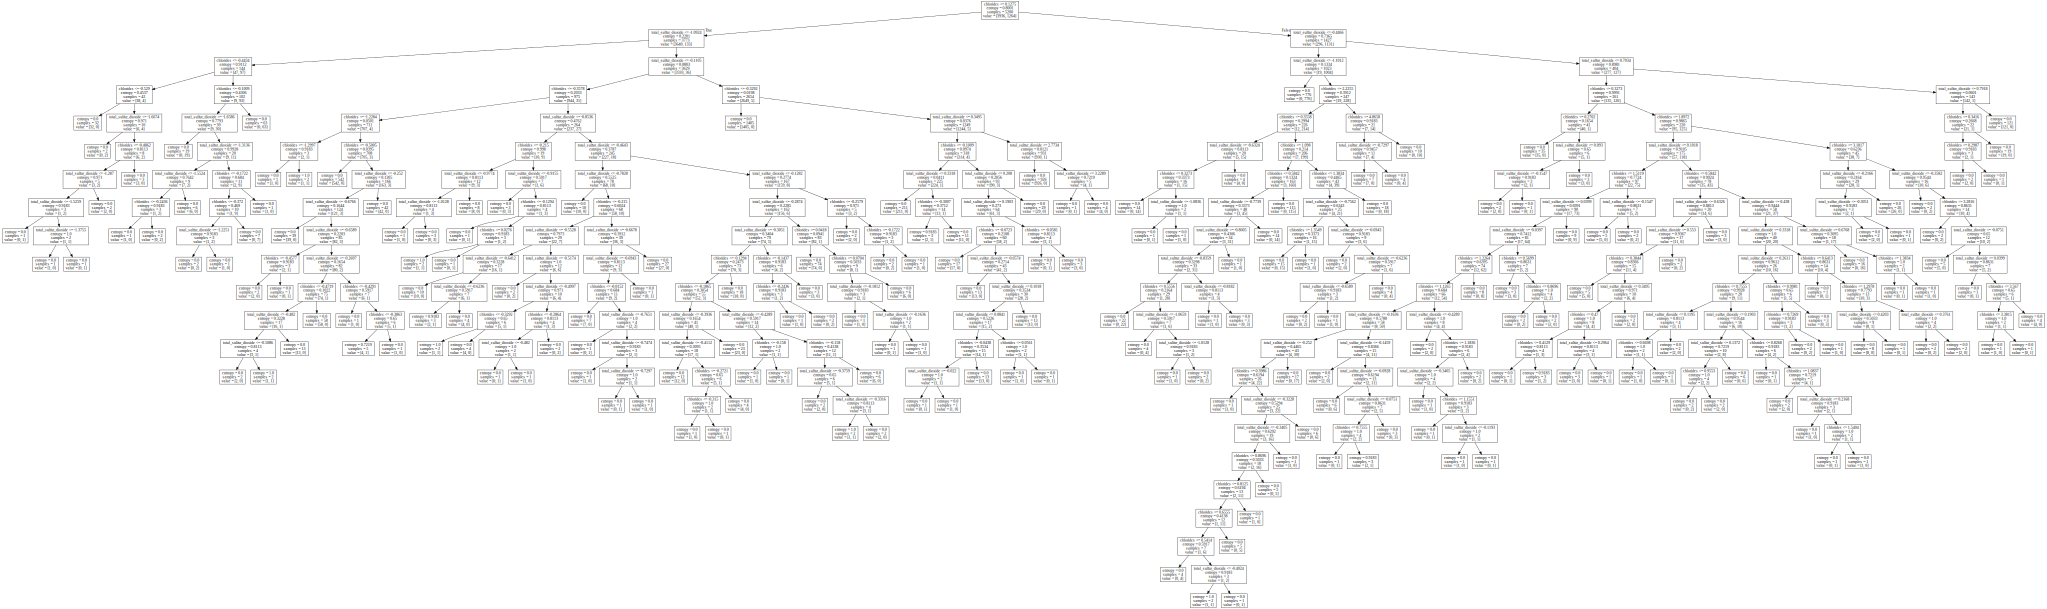

In [202]:
Source( tree.export_graphviz(twoColumnsModel.tree_model, out_file=None, feature_names=wine_train_subset1.columns))

### Summary 

1. Classification results (using all attributes)
  * Accuracy: 99.23  
  * AUC: 0.987020200453 
  
2. Classification results (using the most important three attributes)
  * Accuracy: 98.61 
  * AUC: 0.981889409501 
 
3. Classification results (using the most important two attributes)
  * Accuracy: 98.15
  * AUC: 0.974879759208
  
4. Classification results (using the most important attribute)
  * Accuracy: 92.91 

##### Findings and Insights

* The best AUC that we can achieve is 0.987020200453 and we can achieve it when we build our model based on all of the attributes. 
* We will need two attributes at minimum to achieve accuracy higher than 95%. The less number of attributes we use, the less accurate our model gets.
* When we compare Decision Tree classifier to Naive Bayes that we performed last week, we see that Decision Tree classifier is more robust and provided us better accuracy results. When we built our model using only one attribute, the accuracy of the Naive Bayes classifier dropped significantly while that of Decision Tree remained above 90%. 